In [1]:
import cv2
import os
import numpy as np

In [2]:
def extract_frames_from_videos(video_dir, output_dir, frame_rate=5):
    """Extract frames from videos and save them into subdirectories based on the video category."""
    class_names = ['LegalBall','LBW']  # Define class labels

    for class_name in class_names:
        class_folder = os.path.join(video_dir, class_name)
        output_class_dir = os.path.join(output_dir, 'extracted_frames', class_name)
        os.makedirs(output_class_dir, exist_ok=True)  # Create the output directory if it doesn't exist

        for video_file in os.listdir(class_folder):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(class_folder, video_file)
                video = cv2.VideoCapture(video_path)
                success, image = video.read()
                frame_count = 0
                while success:
                    if frame_count % frame_rate == 0:  # Capture frame at specific intervals
                        frame_filename = f"{os.path.splitext(video_file)[0]}_frame_{frame_count}.jpg"
                        frame_output_path = os.path.join(output_class_dir, frame_filename)
                        image_resized = cv2.resize(image, (224, 224))  # Resize for CNN
                        cv2.imwrite(frame_output_path, image_resized)  # Save frame
                    success, image = video.read()
                    frame_count += 1

In [3]:
video_dir = 'LBW/'  # Path to your dataset directory 
output_dir = 'LBW/data/'  # Root directory where all data will be saved

In [4]:
extract_frames_from_videos(video_dir, output_dir)

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2

In [6]:
def load_data_from_frames(output_dir):
    """Load frames from directories and prepare the data for training."""
    class_names = ['LegalBall','LBW']
    data = []
    labels = []

    for class_id, class_name in enumerate(class_names):
        class_folder = os.path.join(output_dir, 'extracted_frames', class_name)
        for frame_file in os.listdir(class_folder):
            if frame_file.endswith('.jpg'):
                frame_path = os.path.join(class_folder, frame_file)
                image = cv2.imread(frame_path)
                data.append(image)
                labels.append(class_id)  # Assign class label

    data = np.array(data)
    labels = np.array(labels)
    
    # Normalize the frames
    data = data.astype('float32') / 255.0
    
    # One-hot encode the labels
    labels = to_categorical(labels, num_classes=4)

    return data, labels


In [7]:
# Load frames and labels
frames_data, labels_data = load_data_from_frames(output_dir)

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(frames_data, labels_data, test_size=0.2, random_state=42)

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Define the model
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    
    # CNN part wrapped in TimeDistributed (to apply the CNN to each frame)
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Flatten()))
    
    # LSTM part
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    
    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer (4 classes: No Ball, Legal Ball, Wide, LBW)
    model.add(Dense(4, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
# Define the input shape: (10 frames, 224x224 pixels, 3 color channels)
input_shape = (10, 224, 224, 3)
model = create_cnn_lstm_model(input_shape)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
#print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 222, 222, 32)    │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 222, 222, 32)    │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 111, 111, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 109, 109, 64)    │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 10, 109, 109, 64)    │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 10, 54, 54, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 10, 52, 52, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 10, 52, 52, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 10, 26, 26, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 10, 86528)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │      22,167,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,270,788 (84.96 MB)

 Trainable params: 22,270,340 (84.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Data augmentation (to reduce overfitting and introduce more data variety)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [14]:
# Apply augmentation frame by frame before creating sequences
def augment_frames(X_train):
    augmented_frames = []
    for frame in X_train:
        augmented_frame = datagen.random_transform(frame)
        augmented_frames.append(augmented_frame)
    return np.array(augmented_frames)


In [15]:
# Function to create frame sequences for the model
def create_frame_sequences(data, labels, sequence_length=10):
    sequences = []
    sequence_labels = []
    
    for i in range(0, len(data) - sequence_length, sequence_length):
        sequences.append(data[i:i + sequence_length])
        sequence_labels.append(labels[i + sequence_length - 1])  # Use the label of the last frame in the sequence
    
    return np.array(sequences), np.array(sequence_labels)

In [16]:
# Example data (X_train, y_train) should be processed with your dataset
# Assuming X_train and y_train are preprocessed
# Manually augment data frame by frame
X_train_augmented = augment_frames(X_train)

In [17]:
# Group the frames into sequences of 10 frames each
X_train_seq, y_train_seq = create_frame_sequences(X_train_augmented, y_train, sequence_length=10)
X_test_seq, y_test_seq = create_frame_sequences(X_test, y_test, sequence_length=10)

In [18]:
# Define learning rate scheduler and checkpoint
checkpoint = ModelCheckpoint('lbw_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [19]:
# Train the model using the sequences of frames
history = model.fit(X_train_seq, y_train_seq,
                    epochs=50,
                    batch_size=4,
                    validation_data=(X_test_seq, y_test_seq),
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4385 - loss: 1.0512
Epoch 1: val_loss improved from inf to 1.26944, saving model to lbw_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.4423 - loss: 1.0483 - val_accuracy: 0.5185 - val_loss: 1.2694 - learning_rate: 1.0000e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6990 - loss: 0.7623
Epoch 2: val_loss improved from 1.26944 to 0.36388, saving model to lbw_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - accuracy: 0.7005 - loss: 0.7603 - val_accuracy: 0.9259 - val_loss: 0.3639 - learning_rate: 1.0000e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8224 - loss: 0.5495
Epoch 3: val_loss improved from 0.36388 to 0.28475, saving model to lbw_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.8231 - loss: 0.5479 - val_accuracy: 1.0000 - val_loss: 0.2847 - learning_rate: 1.0000e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8930 - l

In [20]:
import pandas as pd

In [21]:
# Create the logs directory
logs_dir = os.path.join(output_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)

In [22]:
# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)

In [23]:
# Save the training history to CSV
log_file_path = os.path.join(logs_dir, 'training_log.csv')
history_df.to_csv(log_file_path, index=False)

In [24]:
import matplotlib.pyplot as plt

In [25]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

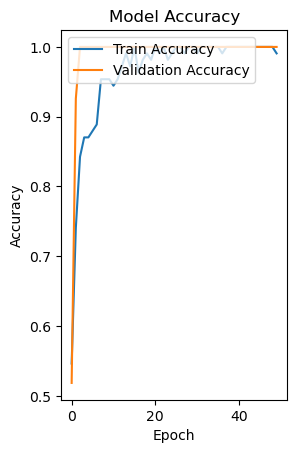

In [26]:
# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

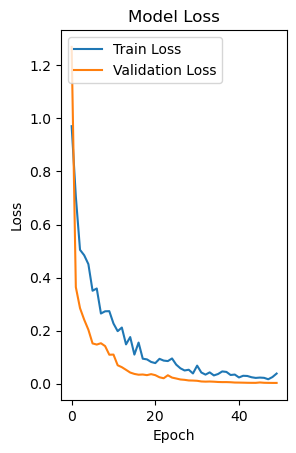

In [27]:
# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

In [28]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [29]:
from tensorflow.keras.models import load_model

In [30]:
# Load the saved model
model = load_model('lbw_model.keras')

In [31]:
import cv2
import numpy as np

In [32]:
def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30):
    """
    Preprocess the input video to extract frames and resize them for the model.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize the frame to the size expected by the model (frame_size)
        frame_resized = cv2.resize(frame, frame_size)
        
        # Optionally normalize the frame (if required by the model)
        frame_normalized = frame_resized / 255.0  # Example for normalization
        
        frames.append(frame_normalized)

        # Skip frames to match the desired frame rate (if needed)
        # if frame_count % frame_rate == 0:
        #     frames.append(frame_normalized)
    
    cap.release()
    
    # Convert the list of frames to a numpy array
    frames = np.array(frames)

    # Make sure the shape of the frames matches the input shape of the model
    return frames

In [33]:
# Testing
video_path = 'Test_Video_Data/lbw_out.mp4'
video_frames = preprocess_video(video_path)

In [34]:
# Make prediction on the processed frames
prediction = model.predict(np.expand_dims(video_frames, axis=0))  # Add batch dimension

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [35]:
# If the model outputs probabilities, decide on the threshold
threshold = 0.5
lbw_out = prediction[0][1] > threshold

In [36]:
if lbw_out:
    print("The video is classified as LBW out.")
else:
    print("The video is classified as Not LBW out.")

The video is classified as LBW out.


# Evaluation

## recall_score, precision_score, f1_score, accuracy_score

In [37]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.utils import resample

# Load the model
model = load_model('lbw_model.keras')

# Function to preprocess videos (resize and normalize frames)
def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30):
    """
    Preprocess the input video to extract frames and resize them for the model.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize and normalize the frame
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0  # Normalize to [0, 1]
        
        frames.append(frame_normalized)
    
    cap.release()
    frames = np.array(frames)
    return frames

# Function to evaluate the model with class balancing
def evaluate_model(model, dataset_path, frame_size=(224, 224)):
    true_labels = []
    pred_labels = []

    # Prepare lists to hold class samples
    lbw_samples = []
    legalball_samples = []

    # Iterate through the dataset directories (LBW and LegalBall)
    for class_name in ['LBW', 'LegalBall']:
        class_folder = os.path.join(dataset_path, class_name)
        
        for video_file in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_file)
            frames = preprocess_video(video_path, frame_size)
            
            # Make prediction
            prediction = model.predict(np.expand_dims(frames, axis=0))  # Add batch dimension
            
            # Print raw predictions for debugging (before applying threshold)
            print(f"Raw prediction for {video_file}: {prediction}")
            
            lbw_out = prediction[0][1] > 0.5  # Classifying as LBW if probability > 0.5
            
            # Assign true label (1 for LBW, 0 for LegalBall)
            true_label = 1 if class_name == 'LBW' else 0
            true_labels.append(true_label)
            pred_labels.append(int(lbw_out))
            
            # Collect the samples in separate lists
            if class_name == 'LBW':
                lbw_samples.append((frames, int(lbw_out)))
            else:
                legalball_samples.append((frames, int(lbw_out)))

    # Class balancing: Over-sample the minority class (if required)
    if len(lbw_samples) < len(legalball_samples):
        # Over-sample the LBW class
        lbw_samples = resample(lbw_samples, replace=True, n_samples=len(legalball_samples), random_state=42)
    elif len(legalball_samples) < len(lbw_samples):
        # Over-sample the LegalBall class
        legalball_samples = resample(legalball_samples, replace=True, n_samples=len(lbw_samples), random_state=42)

    # Combine the balanced samples back together
    balanced_samples = lbw_samples + legalball_samples

    # Shuffle the dataset to avoid any ordering bias
    np.random.shuffle(balanced_samples)

    # Re-create the true_labels and pred_labels from the balanced dataset
    true_labels_balanced = []
    pred_labels_balanced = []
    for frames, true_label in balanced_samples:
        # Make a prediction
        prediction = model.predict(np.expand_dims(frames, axis=0))  # Add batch dimension
        lbw_out = prediction[0][1] > 0.5  # Classifying as LBW out if probability > 0.5
        
        true_labels_balanced.append(true_label)
        pred_labels_balanced.append(int(lbw_out))

    # Calculate metrics
    recall = recall_score(true_labels_balanced, pred_labels_balanced)
    precision = precision_score(true_labels_balanced, pred_labels_balanced)
    f1 = f1_score(true_labels_balanced, pred_labels_balanced)
    accuracy = accuracy_score(true_labels_balanced, pred_labels_balanced)
    
    return recall, precision, f1, accuracy

# Main evaluation
def main():
    dataset_path = 'LBW'  # Replace with the path to your dataset folder
    recall, precision, f1, accuracy = evaluate_model(model, dataset_path)

    # Print results
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

# Call the main function to run the evaluation
if __name__ == '__main__':
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
Raw prediction for lbw out 2.mp4: [[6.1610453e-03 9.9275243e-01 5.5822055e-04 5.2829040e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Raw prediction for lbw1.mp4: [[1.3524966e-03 9.9808818e-01 2.7904220e-04 2.8025405e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
Raw prediction for lbw10.mp4: [[2.4541738e-03 9.9642473e-01 5.8466580e-04 5.3641951e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
Raw prediction for lbw10_mirr.mp4: [[2.3055689e-03 9.9689639e-01 3.3221484e-04 4.6587127e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
Raw prediction for lbw11.mp4: [[1.1198519e-03 9.9849129e-01 1.9541828e-04 1.9336811e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Raw prediction for lbw11_mirr.mp4: [[1.0644714e-03 9.9856144e-01 1.8841785e-04 1.8571195e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Raw prediction for lbw12.mp4: [[1.7819289e-03 9.9772114e-01 2.3423973e-04 2.6274315e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Raw prediction for lbw12_mirr.mp4: [[1.6361123e-0

## ROC Curve and AUC

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
Raw prediction for lbw out 2.mp4: [[6.1610453e-03 9.9275243e-01 5.5822055e-04 5.2829040e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Raw prediction for lbw1.mp4: [[1.3524966e-03 9.9808818e-01 2.7904220e-04 2.8025405e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Raw prediction for lbw10.mp4: [[2.4541738e-03 9.9642473e-01 5.8466580e-04 5.3641951e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
Raw prediction for lbw10_mirr.mp4: [[2.3055689e-03 9.9689639e-01 3.3221484e-04 4.6587127e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
Raw prediction for lbw11.mp4: [[1.1198519e-03 9.9849129e-01 1.9541828e-04 1.9336811e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Raw prediction for lbw11_mirr.mp4: [[1.0644714e-03 9.9856144e-01 1.8841785e-04 1.8571195e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Raw prediction for lbw12.mp4: [[1.7819289e-03 9.9772114e-01 2.3423973e-04 2.6274315e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Raw prediction for lbw12_mirr.mp4: [[1.6361123e-0

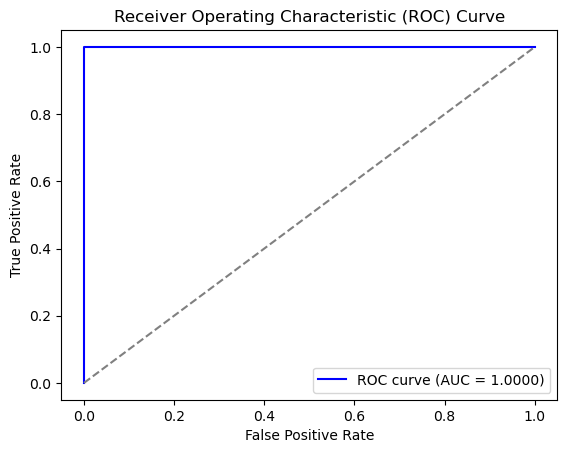

In [38]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Load the model
model = load_model('lbw_model.keras')

# Function to preprocess videos (resize and normalize frames)
def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30):
    """
    Preprocess the input video to extract frames and resize them for the model.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize and normalize the frame
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0  # Normalize to [0, 1]
        
        frames.append(frame_normalized)
    
    cap.release()
    frames = np.array(frames)
    return frames

# Function to evaluate the model with class balancing
def evaluate_model(model, dataset_path, frame_size=(224, 224)):
    true_labels = []
    pred_labels = []
    pred_probs = []  # Store predicted probabilities for ROC and AUC

    # Prepare lists to hold class samples
    lbw_samples = []
    legalball_samples = []

    # Iterate through the dataset directories (LBW and LegalBall)
    for class_name in ['LBW', 'LegalBall']:
        class_folder = os.path.join(dataset_path, class_name)
        
        for video_file in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_file)
            frames = preprocess_video(video_path, frame_size)
            
            # Make prediction
            prediction = model.predict(np.expand_dims(frames, axis=0))  # Add batch dimension
            
            # Print raw predictions for debugging (before applying threshold)
            print(f"Raw prediction for {video_file}: {prediction}")
            
            lbw_out = prediction[0][1] > 0.5  # Classifying as LBW if probability > 0.5
            
            # Assign true label (1 for LBW, 0 for LegalBall)
            true_label = 1 if class_name == 'LBW' else 0
            true_labels.append(true_label)
            pred_labels.append(int(lbw_out))
            pred_probs.append(prediction[0][1])  # Store the probability of the positive class
            
            # Collect the samples in separate lists
            if class_name == 'LBW':
                lbw_samples.append((frames, int(lbw_out)))
            else:
                legalball_samples.append((frames, int(lbw_out)))

    # Class balancing: Over-sample the minority class (if required)
    if len(lbw_samples) < len(legalball_samples):
        # Over-sample the LBW class
        lbw_samples = resample(lbw_samples, replace=True, n_samples=len(legalball_samples), random_state=42)
    elif len(legalball_samples) < len(lbw_samples):
        # Over-sample the LegalBall class
        legalball_samples = resample(legalball_samples, replace=True, n_samples=len(lbw_samples), random_state=42)

    # Combine the balanced samples back together
    balanced_samples = lbw_samples + legalball_samples

    # Shuffle the dataset to avoid any ordering bias
    np.random.shuffle(balanced_samples)

    # Re-create the true_labels and pred_labels from the balanced dataset
    true_labels_balanced = []
    pred_labels_balanced = []
    pred_probs_balanced = []  # Probabilities for balanced dataset
    for frames, true_label in balanced_samples:
        # Make a prediction
        prediction = model.predict(np.expand_dims(frames, axis=0))  # Add batch dimension
        lbw_out = prediction[0][1] > 0.5  # Classifying as LBW out if probability > 0.5
        
        true_labels_balanced.append(true_label)
        pred_labels_balanced.append(int(lbw_out))
        pred_probs_balanced.append(prediction[0][1])

    # Calculate metrics
    recall = recall_score(true_labels_balanced, pred_labels_balanced)
    precision = precision_score(true_labels_balanced, pred_labels_balanced)
    f1 = f1_score(true_labels_balanced, pred_labels_balanced)
    accuracy = accuracy_score(true_labels_balanced, pred_labels_balanced)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_labels_balanced, pred_probs_balanced)
    auc = roc_auc_score(true_labels_balanced, pred_probs_balanced)
    
    return recall, precision, f1, accuracy, fpr, tpr, auc

# Main evaluation
def main():
    dataset_path = 'LBW'  # Replace with the path to your dataset folder
    recall, precision, f1, accuracy, fpr, tpr, auc = evaluate_model(model, dataset_path)

    # Print results
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc:.4f}')

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Call the main function to run the evaluation
if __name__ == '__main__':
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Raw prediction for lbw1.mp4: [[1.2372764e-03 9.9785608e-01 1.9207671e-04 7.1454578e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Raw prediction for lbw10.mp4: [[0.23342402 0.74375045 0.01148251 0.01134302]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Raw prediction for lbw10_mirr.mp4: [[0.09911558 0.8744247  0.0136382  0.0128216 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Raw prediction for lbw11.mp4: [[1.9216752e-03 9.9677473e-01 2.4798283e-04 1.0556742e-03]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
Raw prediction for lbw11_mirr.mp4: [[1.4966319e-03 9.9782360e-01 1.3268524e-04 5.4705079e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Raw prediction for lbw12.mp4: [[3.6243696e-03 9.9553043e-01 2.0875399e-04 6.3645776e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Raw prediction for lbw12_mirr.mp4: [[3.8758398e-03 9.9496293e-01 2.7409021e-04 8.8714156e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
Raw prediction for lbw13 .mp4: [[1.4899360e-03 9.9590486e-01 4.0631552e-04

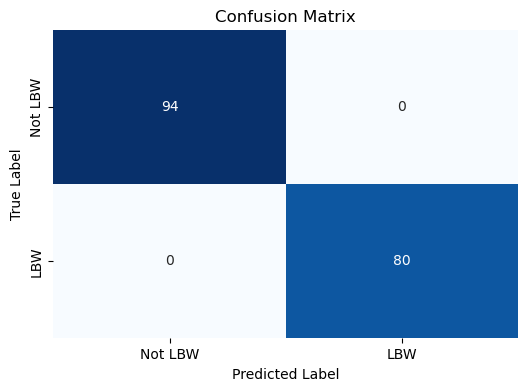

In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model
model = load_model('lbw_model.keras')

# Function to preprocess videos (resize and normalize frames)
def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30):
    """
    Preprocess the input video to extract frames and resize them for the model.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize and normalize the frame
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0  # Normalize to [0, 1]
        
        frames.append(frame_normalized)
    
    cap.release()
    frames = np.array(frames)
    return frames

# Function to evaluate the model with class balancing
def evaluate_model(model, dataset_path, frame_size=(224, 224)):
    true_labels = []
    pred_labels = []
    pred_probs = []  # Store predicted probabilities for AUC

    # Prepare lists to hold class samples
    lbw_samples = []
    legalball_samples = []

    # Iterate through the dataset directories (LBW and LegalBall)
    for class_name in ['LBW', 'LegalBall']:
        class_folder = os.path.join(dataset_path, class_name)
        
        for video_file in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_file)
            frames = preprocess_video(video_path, frame_size)
            
            # Make prediction
            prediction = model.predict(np.expand_dims(frames, axis=0))  # Add batch dimension
            
            # Print raw predictions for debugging (before applying threshold)
            print(f"Raw prediction for {video_file}: {prediction}")
            
            lbw_out = prediction[0][1] > 0.5  # Classifying as LBW if probability > 0.5
            
            # Assign true label (1 for LBW, 0 for LegalBall)
            true_label = 1 if class_name == 'LBW' else 0
            true_labels.append(true_label)
            pred_labels.append(int(lbw_out))
            pred_probs.append(prediction[0][1])  # Store the probability of the positive class
            
            # Collect the samples in separate lists
            if class_name == 'LBW':
                lbw_samples.append((frames, int(lbw_out)))
            else:
                legalball_samples.append((frames, int(lbw_out)))

    # Class balancing: Over-sample the minority class (if required)
    if len(lbw_samples) < len(legalball_samples):
        # Over-sample the LBW class
        lbw_samples = resample(lbw_samples, replace=True, n_samples=len(legalball_samples), random_state=42)
    elif len(legalball_samples) < len(lbw_samples):
        # Over-sample the LegalBall class
        legalball_samples = resample(legalball_samples, replace=True, n_samples=len(lbw_samples), random_state=42)

    # Combine the balanced samples back together
    balanced_samples = lbw_samples + legalball_samples

    # Shuffle the dataset to avoid any ordering bias
    np.random.shuffle(balanced_samples)

    # Re-create the true_labels and pred_labels from the balanced dataset
    true_labels_balanced = []
    pred_labels_balanced = []
    pred_probs_balanced = []  # Probabilities for balanced dataset
    for frames, true_label in balanced_samples:
        # Make a prediction
        prediction = model.predict(np.expand_dims(frames, axis=0))  # Add batch dimension
        lbw_out = prediction[0][1] > 0.5  # Classifying as LBW out if probability > 0.5
        
        true_labels_balanced.append(true_label)
        pred_labels_balanced.append(int(lbw_out))
        pred_probs_balanced.append(prediction[0][1])

    # Calculate metrics
    recall = recall_score(true_labels_balanced, pred_labels_balanced)
    precision = precision_score(true_labels_balanced, pred_labels_balanced)
    f1 = f1_score(true_labels_balanced, pred_labels_balanced)
    accuracy = accuracy_score(true_labels_balanced, pred_labels_balanced)

    # Compute AUC
    auc = roc_auc_score(true_labels_balanced, pred_probs_balanced)

    # Compute Confusion Matrix
    cm = confusion_matrix(true_labels_balanced, pred_labels_balanced)
    
    return recall, precision, f1, accuracy, auc, cm

# Function to plot Confusion Matrix
def plot_confusion_matrix(cm, labels=['Not LBW', 'LBW']):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Main evaluation
def main():
    dataset_path = 'LBW'  # Replace with the path to your dataset folder
    recall, precision, f1, accuracy, auc, cm = evaluate_model(model, dataset_path)

    # Print results
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc:.4f}')

    # Plot Confusion Matrix
    plot_confusion_matrix(cm)

# Call the main function to run the evaluation
if __name__ == '__main__':
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/ste

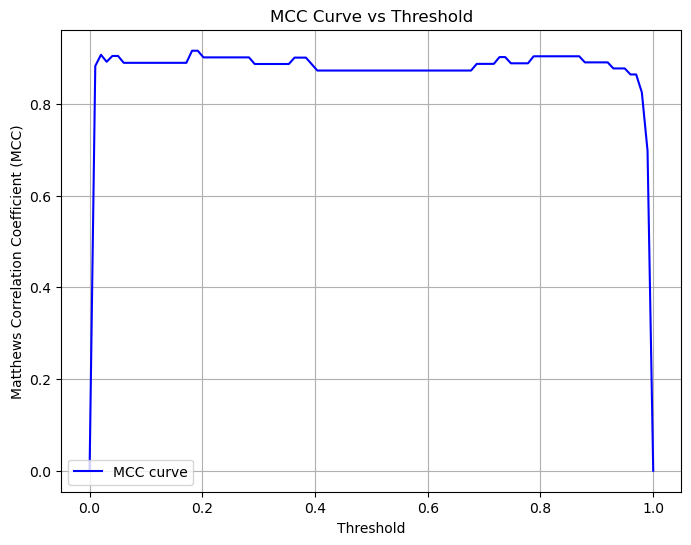

In [15]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt

# Load the model
model = load_model('lbw_model.keras')

# Function to preprocess videos (resize and normalize frames)
def preprocess_video(video_path, frame_size=(224, 224), frame_rate=30):
    """
    Preprocess the input video to extract frames and resize them for the model.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize and normalize the frame
        frame_resized = cv2.resize(frame, frame_size)
        frame_normalized = frame_resized / 255.0  # Normalize to [0, 1]
        
        frames.append(frame_normalized)
    
    cap.release()
    frames = np.array(frames)
    return frames

# Function to evaluate the model with class balancing
def evaluate_model(model, dataset_path, frame_size=(224, 224)):
    true_labels = []
    pred_labels = []
    pred_probs = []  # Store predicted probabilities for MCC calculation

    # Iterate through the dataset directories (LBW and LegalBall)
    for class_name in ['LBW', 'LegalBall']:
        class_folder = os.path.join(dataset_path, class_name)
        
        for video_file in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_file)
            frames = preprocess_video(video_path, frame_size)
            
            # Make prediction
            prediction = model.predict(np.expand_dims(frames, axis=0))  # Add batch dimension
            
            # Get the probability of the positive class (LBW)
            pred_probs.append(prediction[0][1])
            
            # Assign true label (1 for LBW, 0 for LegalBall)
            true_label = 1 if class_name == 'LBW' else 0
            true_labels.append(true_label)
    
    return true_labels, pred_probs

# Function to plot MCC curve
def plot_mcc_curve(true_labels, pred_probs):
    thresholds = np.linspace(0, 1, 100)  # Test thresholds from 0 to 1
    mcc_scores = []

    # Calculate MCC at each threshold
    for threshold in thresholds:
        pred_labels = [1 if prob >= threshold else 0 for prob in pred_probs]
        mcc = matthews_corrcoef(true_labels, pred_labels)
        mcc_scores.append(mcc)

    # Plot MCC as a curve
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, mcc_scores, color='blue', label='MCC curve')
    plt.xlabel('Threshold')
    plt.ylabel('Matthews Correlation Coefficient (MCC)')
    plt.title('MCC Curve vs Threshold')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()

# Main evaluation
def main():
    dataset_path = 'LBW'  # Replace with the path to your dataset folder
    true_labels, pred_probs = evaluate_model(model, dataset_path)

    # Plot MCC curve
    plot_mcc_curve(true_labels, pred_probs)

# Call the main function to run the evaluation
if __name__ == '__main__':
    main()
